In [1]:
#
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import json
import codecs
import numpy as np
from find_exit import FindExit
from density_generation import DMap
from matplotlib import pyplot as plt
from copy import copy
from path_finder import  AStarDynamic, AStarStatic, relocate_paths_xy
from locate_preprocess import relocate_node, expand_exits
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# get frame data
data = []
with codecs.open('../map_data/people_activity_0524.json','rU','utf-8') as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
# get map_data
map_data = pd.read_csv('./new_map/mask_floor0.csv', header=None, sep=' ')
# map_data = pd.read_csv('../map_data/mask_floor0.csv', header=None)
map_data = np.array(-(map_data - 1)).astype(int)

In [4]:
# get exit_list
# 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
exits = pd.read_csv('../map_data/exit_floor0.csv',header=None, )
exits = exits.T

# 坐标-->索引
exits[0] = exits[0].astype(float) 
'''看这里'''
exits[1] = 230 - exits[1].astype(float)

exit_list = np.array(exits.ix[:,[1,0]]) #令0-230的在前面

map_data = expand_exits(exit_list.astype(int), map_data)

In [5]:
# gate的坐标不要转换. 
gates = pd.read_table('./new_map/admiralty_gates.txt', header=None, sep=' ')[[1,0]]

gates.columns = range(gates.shape[1])

exits_all = pd.concat([gates, pd.DataFrame(exit_list)], axis=0)[[1,0]]
exits_all.index = range(exits_all.shape[0])
exits_all.columns = range(exits_all.shape[1])

In [88]:
small_cluster = data[1]['small_clusters']

In [89]:
# get cluster_list

small_cluster = pd.DataFrame(small_cluster)
small_cluster = small_cluster[small_cluster[4] > 0]
small_cluster.index = range(len(small_cluster))

# 坐标-->索引
small_cluster[0] = small_cluster[0] 
'''看这里'''
small_cluster[1] = 230 - small_cluster[1]

cluster_list = np.array(small_cluster[[1,0]]).astype(int)
cl = zip(cluster_list.tolist(), small_cluster[4]) # cl = [([197, 9], 1.0),...,([],1.0)]

In [90]:
# 创建初始状态密度图
M = DMap(sigma=10)
# density_map这个函数是按照small_cluster的xy写的
# x是0-50,y是0-230
crowd_density = M.density_map(map_data.shape, small_cluster, crowd=True)

# exits_list的x大,y小,所以xy坐标需要换一下位置, 
# exits_density = M.density_map(map_data.shape, pd.DataFrame(exit_list[:,[1,0]]), sigma=5)
exits_density = M.density_map(map_data.shape, exits_all[[1,0]], sigma=20)
show_data = (crowd_density-exits_density) # density的图

# 1. Exit Selection

In [98]:
# find exits for each cluster
exit_finder = FindExit(k_attr=100, k_repul=5,sigma_attr=50, sigma_repul=50)
exits_matched = pd.DataFrame(exit_finder.find_exit_for_all(cl, np.array(gates).tolist()))

exits_matched = pd.concat([small_cluster, exits_matched], axis=1, ignore_index=True)

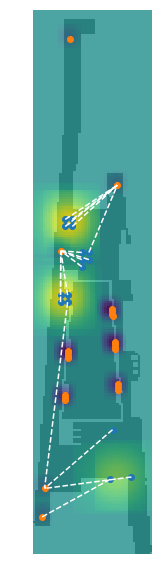

In [99]:
# 进行画图
plt.rcParams['figure.figsize'] = (10,10) 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.scatter(small_cluster[0], small_cluster[1],)

# plt.scatter(exits[0], exits[1])
plt.scatter(exits_all[0], exits_all[1],)

# plot the simple path
# yy is the results of find_exit and concate with small cluster
p = exits_matched[[0,7]]
q = exits_matched[[1,6]]
for i in range(len(p)):
    x1 = list(p.iloc[i])
    y1 = list(q.iloc[i])
    plt.plot(x1, y1,c='w', linestyle='--')
    
# plt.imshow(map_data, cmap='gray')
# plt.imshow(5*crowd_density- 0.001*map_data - 4*exits_density)
plt.imshow(M.normlize(map_data), alpha=0.7, cmap='gray')
# plt.imshow(map_data_new, alpha=0.8, cmap='gray')
plt.imshow(M.normlize(crowd_density-exits_density), alpha=0.8,)



plt.axis('off')
plt.show()

In [52]:
big_cluster = pd.DataFrame(data[1]['big_clusters'])

In [53]:
big_cluster

,0,1,2,3,4,5
0,41,33,0.000000,0.000000,1.000000,25
1,13,109,0.000000,0.000000,0.775510,49
2,15,141,0.007929,2.428544,0.653061,49
3,32,32,0.000000,0.000000,1.000000,25
4,23,125,0.042061,-0.007700,0.061728,81
5,32,55,0.046247,0.212897,0.040816,49


In [54]:
big_cluster[1] = 230 - big_cluster[1]

In [55]:
big_cluster

,0,1,2,3,4,5
0,41,197,0.000000,0.000000,1.000000,25
1,13,121,0.000000,0.000000,0.775510,49
2,15,89,0.007929,2.428544,0.653061,49
3,32,198,0.000000,0.000000,1.000000,25
4,23,105,0.042061,-0.007700,0.061728,81
5,32,175,0.046247,0.212897,0.040816,49


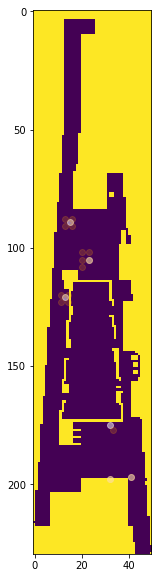

In [40]:
plt.scatter(big_cluster[0], big_cluster[1], alpha=0.5, c='w')
plt.scatter(small_cluster[0], small_cluster[1], alpha=0.2, c='orange')
plt.imshow(map_data)

In [43]:
small_cluster

,0,1,2,3,4,5
0,41,197,0.000000,0.000000,1.000000,f1_18
1,11,123,0.000000,0.000000,0.555556,f1_08
2,11,120,0.000000,0.000000,1.000000,f1_01
3,14,123,0.000000,0.000000,1.000000,f1_01
4,14,120,0.000000,0.000000,0.555556,f1_01
5,13,91,0.041608,-0.966673,1.000000,f1_01
6,13,88,0.000000,0.000000,1.000000,f1_01
7,16,91,0.047815,2.234372,0.444444,f1_01
8,16,88,0.034580,2.284376,0.777778,f1_01
9,32,198,0.000000,0.000000,1.000000,f1_18


In [50]:
big_cluster[6] = big_cluster[4] * big_cluster[5]

In [51]:
big_cluster

,0,1,2,3,4,5,6
0,41,197,0.000000,0.000000,1.000000,25,25.0
1,13,121,0.000000,0.000000,0.775510,49,38.0
2,15,89,0.007929,2.428544,0.653061,49,32.0
3,32,198,0.000000,0.000000,1.000000,25,25.0
4,23,105,0.042061,-0.007700,0.061728,81,5.0
5,32,175,0.046247,0.212897,0.040816,49,2.0


# 2. Path Plan

In [36]:
#start_list1 = [tuple(small_cluster[[1,0]].iloc[i]) for i in range(len(small_cluster))]
start_list1=[relocate_node(tuple(small_cluster[[1,0]].iloc[i]), map_data, 1)  for i in range(len(small_cluster))]
end_list1 = [relocate_node(tuple(exits_matched[[6,7]].astype(int).iloc[i]), map_data,1) for i in range(len(exits_matched))]

start_end = zip(start_list1, end_list1)

## 2.1 Static and classic A*

In [37]:
# find path
finder = AStarStatic(map_data, density=show_data)

paths_sep = finder.find_paths(start_list1, end_list1, weight_d=0)

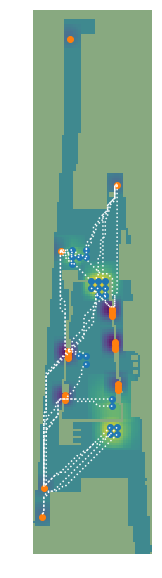

In [38]:
# 画图
plt.rcParams['figure.figsize'] = (10,10) 
plt.scatter( small_cluster[0], small_cluster[1],)
plt.scatter(exits_all[0], exits_all[1])

# 画出路径
for p in paths_sep:
    p = np.array(p).T
    try:
        plt.plot(p[0], p[1],c='w', linestyle=':' )
    except:
        pass
    
show_data = crowd_density-exits_density
masked_data = np.ma.masked_where(map_data==1, show_data)

plt.imshow(map_data, cmap='PiYG',alpha=0.55)
plt.imshow(masked_data, interpolation='none', alpha=0.8)

# plt.imshow(map_data, cmap='PiYG',alpha=0.8)
# plt.imshow(show_data, alpha=0.7)

plt.axis('off')
plt.show()

## 2.2 Static and Crowd Density Concerned A*

In [39]:
# find path
finder = AStarStatic(map_data, density=show_data, gradient=True)

paths_sep = finder.find_paths(start_list1, end_list1, weight_d=1,)

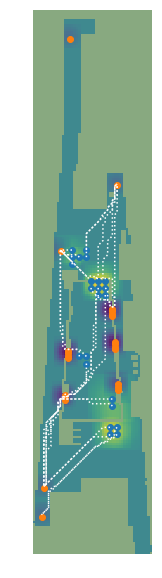

In [40]:
# 画图
plt.rcParams['figure.figsize'] = (10,10) 
plt.scatter( small_cluster[0], small_cluster[1],)
plt.scatter(exits_all[0], exits_all[1])
#plt.scatter(np.array(start_list1)[:,1], np.array(start_list1)[:,0])
# 画出路径
for p in paths_sep:
    p = np.array(p).T
    try:
        plt.plot(p[0], p[1],c='w', linestyle=':' )
    except:
        pass
show_data = crowd_density-exits_density
masked_data = np.ma.masked_where(map_data==1, show_data)

plt.imshow(map_data, cmap='PiYG',alpha=0.55)
plt.imshow(masked_data, interpolation='none', alpha=0.8)

# plt.imshow(map_data, cmap='PiYG',alpha=0.8)
# plt.imshow(show_data, alpha=0.7)

plt.axis('off')
plt.show()

## 2.3 Dynamic Classic A*

In [16]:
#small_cluster2 = small_cluster.copy()
finder = AStarDynamic(map_data, small_cluster, exit_list,)

paths_sep = finder.find_paths(start_list1, end_list1, print_or_not=True, weight_d=0, gradient=False)

0
10
20
30
40
50
0:00:28.671926


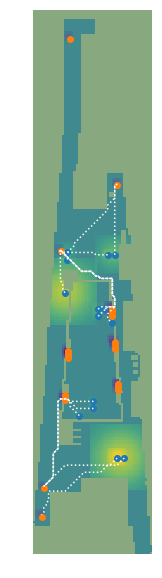

In [17]:
# 画图
plt.rcParams['figure.figsize'] = (10,10) 

plt.scatter( small_cluster[0], small_cluster[1],)

plt.scatter(exits_all[0], exits_all[1])
# 画出路径
for p in paths_sep:
    p = np.array(p).T
    plt.plot(p[0], p[1],c='w', linestyle=':' )

show_data = crowd_density-exits_density
masked_data = np.ma.masked_where(map_data==1, show_data)

plt.imshow(map_data, cmap='PiYG',alpha=0.55)
plt.imshow(masked_data, interpolation='none', alpha=0.8)

# plt.imshow(map_data, cmap='PiYG',alpha=0.8)
# plt.imshow(show_data, alpha=0.7)

plt.axis('off')
plt.show()

## 2.4 Dynamic and Crowd Density Concerned A*

In [18]:
#small_cluster2 = small_cluster.copy()
finder = AStarDynamic(map_data, small_cluster, exit_list,)

paths_sep = finder.find_paths(start_list1, end_list1, print_or_not=True, weight_d=1, gradient=False)

0
10
20
30
40
50
0:00:31.869022


In [19]:
paths_sep = finder.clean_paths_sep(paths_sep)

(-0.5, 49.5, 229.5, -0.5)

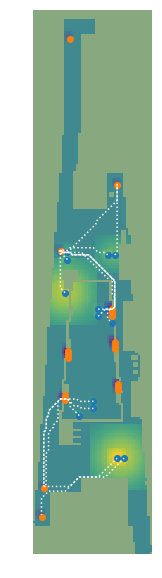

In [22]:
# 画图
plt.rcParams['figure.figsize'] = (10,10) 

plt.scatter( small_cluster[0], small_cluster[1],)

plt.scatter(exits_all[0], exits_all[1])

# 画出路径
for p in paths_sep:
    p = np.array(p).T
    plt.plot(p[0], p[1],c='w', linestyle=':' )

show_data = crowd_density-exits_density
masked_data = np.ma.masked_where(map_data==1, show_data)

plt.imshow(map_data, cmap='PiYG',alpha=0.55)
plt.imshow(masked_data, interpolation='none', alpha=0.8)

# plt.imshow(map_data, cmap='PiYG',alpha=0.8)
# plt.imshow(show_data, alpha=0.7)

plt.axis('off')
#plt.show()

In [184]:
small_cluster

,0,1,2,3,4,5
0,13,119,0.000000,0.000000,0.888889,f2_04
1,35,189,0.000000,0.000000,0.222222,f2_02
2,38,189,0.000000,0.000000,0.888889,f2_02
3,31,103,0.000000,0.000000,0.111111,f2_03
4,34,103,0.000000,0.000000,0.444444,f2_03
5,19,171,0.000000,0.000000,0.111111,f2_01
6,25,168,0.000000,0.000000,0.111111,f2_02
7,25,165,0.015231,2.587890,0.111111,f2_02
8,27,129,0.000423,2.098471,0.111111,f2_03
9,27,126,0.010426,1.300116,0.111111,f2_03


In [61]:
# 转化坐标为左下角为(0,0)
paths_for_databse = relocate_paths_xy(paths_sep)

In [28]:
# 如何写入数据库
paths_list = [[path] for path in paths_sep]

# 如何存入数据库

In [70]:
pd.concat([small_cluster, pd.DataFrame(paths_list)], axis=1)

,0,1,2,3,4,5,0
0,9,197,0.000000,0.000000,1.000000,f1_18,"[(9, 197), (9, 196), (9, 195), (8, 194), (7, 1..."
1,41,119,0.000000,0.000000,1.000000,f1_01,"[(41, 119), (40, 119), (40, 120), (40, 121), (..."
2,37,91,0.000135,0.993442,1.000000,f1_01,"[(37, 91), (36, 91), (36, 92), (36, 93), (36, ..."
3,37,88,0.000000,0.000000,1.000000,f1_01,"[(37, 88), (36, 89), (35, 90), (34, 91), (33, ..."
4,34,91,0.000702,0.814246,0.444444,f1_01,"[(34, 91), (33, 92), (32, 93), (31, 94), (30, ..."
5,34,88,0.000753,0.600198,0.777778,f1_01,"[(34, 88), (33, 89), (32, 90), (31, 91), (30, ..."
6,20,199,0.000000,0.000000,1.000000,f1_13,"[(20, 199), (21, 198), (22, 197), (23, 196), (..."
7,20,196,0.000000,0.000000,0.888889,f1_13,"[(20, 196), (21, 195), (22, 194), (23, 193), (..."
8,17,199,0.000000,0.000000,1.000000,f1_18,"[(17, 199), (18, 198), (19, 197), (19, 196), (..."
9,17,196,0.000000,0.000000,1.000000,f1_18,"[(17, 196), (18, 195), (19, 194), (19, 193), (..."


In [71]:
np.array(_).tolist()

[[9,
  197,
  0.0,
  0.0,
  1.0,
  u'f1_18',
  [(9, 197),
   (9, 196),
   (9, 195),
   (8, 194),
   (7, 193),
   (7, 192),
   (7, 191),
   (7, 190),
   (7, 189),
   (7, 188),
   (7, 187),
   (7, 186),
   (7, 185),
   (7, 184),
   (7, 183),
   (7, 182),
   (7, 181),
   (7, 180),
   (7, 179),
   (7, 178),
   (7, 177),
   (7, 176),
   (7, 175),
   (7, 174),
   (7, 173),
   (8, 172),
   (9, 171),
   (10, 170),
   (11, 169),
   (12, 168),
   (13, 167),
   (14, 166),
   (15, 165),
   (16, 164),
   (16, 163),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162),
   (16, 162)]],
 [41,
  119,
  0.0,
  0.0,
  1.0,
  u'f1_01',
  [(41, 119),
   (40, 119),
   (40, 120),
   (40, 121),
   (40, 122),
   (39, 123),
   (38, 124),
   (38, 125),
   (38, 126),
   (38, 127),
   (38, 12

In [287]:
exits_matched

,0,1,2,3,4,5,6,7
0,9,197,0.000000,0.000000,1.000000,f1_18,160.17,14.54
1,41,119,0.000000,0.000000,1.000000,f1_01,144.66,35.74
2,37,91,0.000135,0.993442,1.000000,f1_01,143.68,35.65
3,37,88,0.000000,0.000000,1.000000,f1_01,125.84,17.15
4,34,91,0.000702,0.814246,0.444444,f1_01,125.84,17.15
5,34,88,0.000753,0.600198,0.777778,f1_01,125.84,17.15
6,20,199,0.000000,0.000000,1.000000,f1_13,164.59,37.04
7,20,196,0.000000,0.000000,0.888889,f1_13,164.59,37.04
8,17,199,0.000000,0.000000,1.000000,f1_18,160.17,14.54
9,17,196,0.000000,0.000000,1.000000,f1_18,160.17,14.54


In [4]:
a = pd.DataFrame([])

In [5]:
a.copy?

frame 0


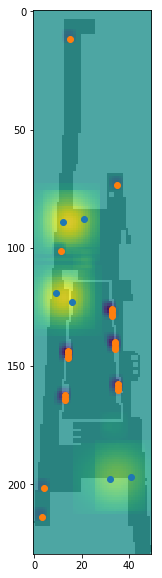

frame 1


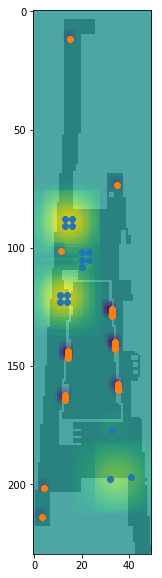

frame 2


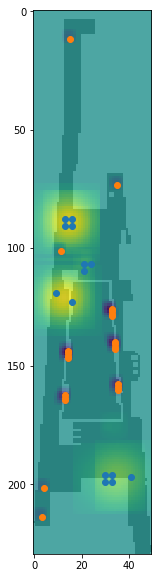

frame 3


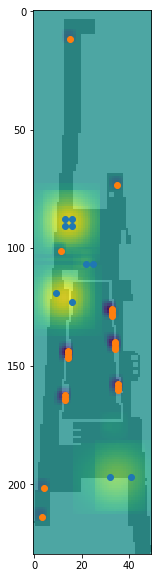

frame 4


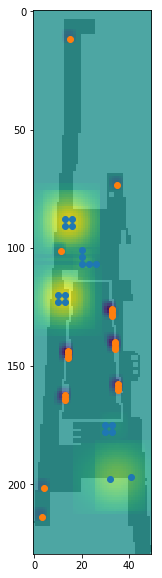

frame 5


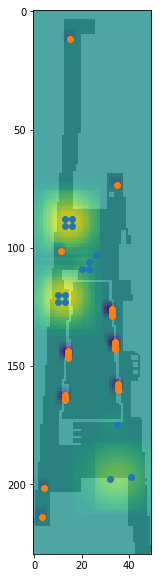

frame 6


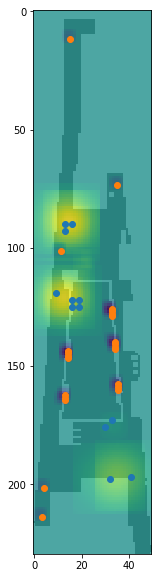

frame 7


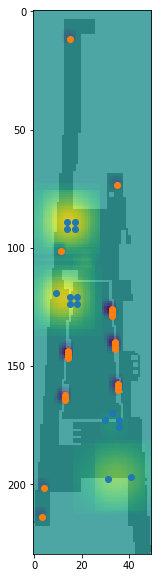

frame 8


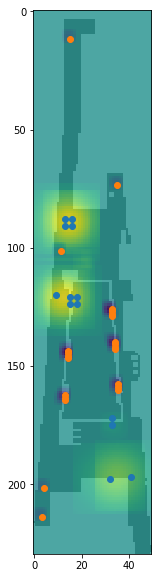

frame 9


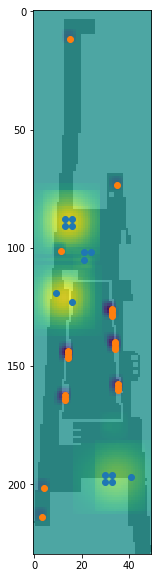

frame 10


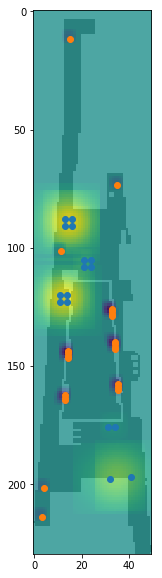

frame 11


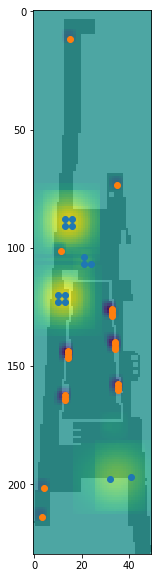

frame 12


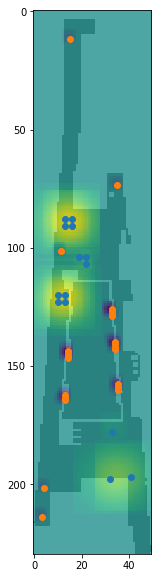

frame 13


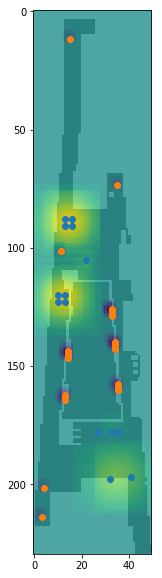

frame 14


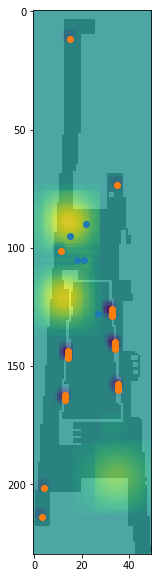

frame 15


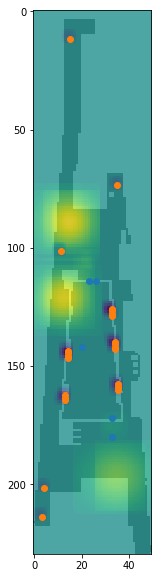

frame 16


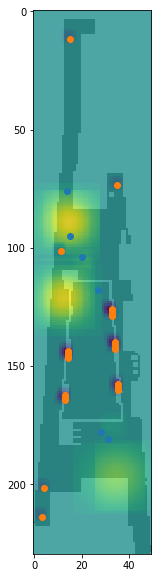

frame 17


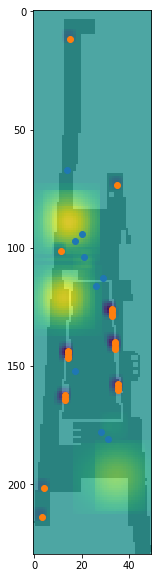

frame 18


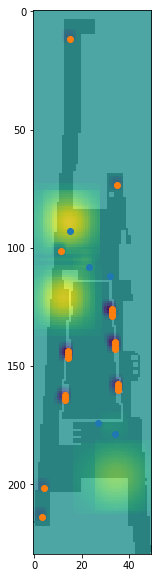

frame 19


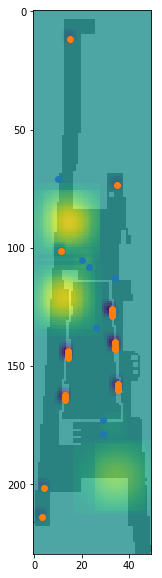

frame 20


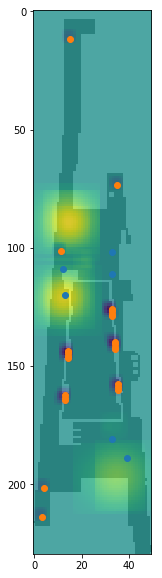

frame 21


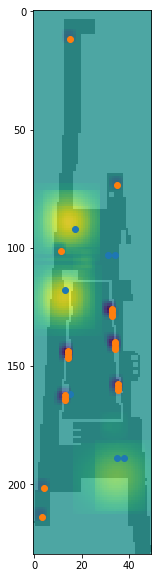

frame 22


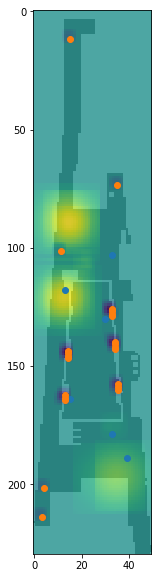

frame 23


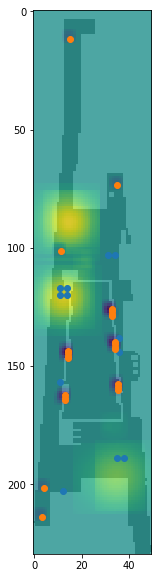

frame 24


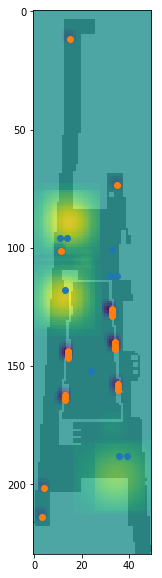

frame 25


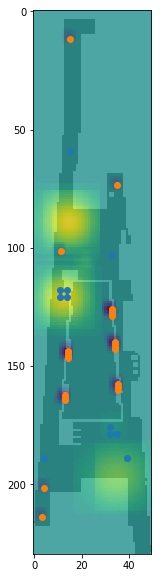

frame 26


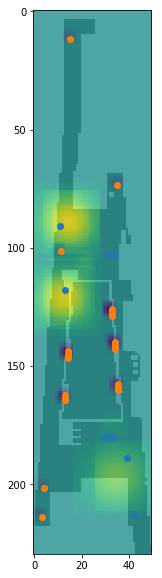

frame 27


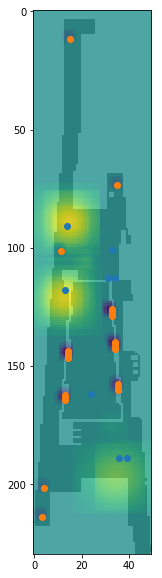

frame 28


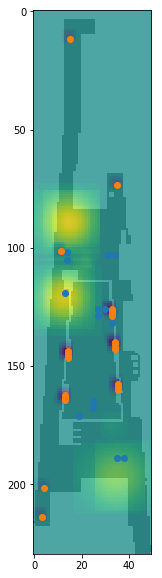

frame 29


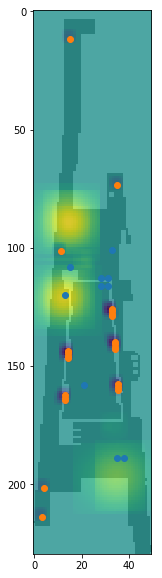

frame 30


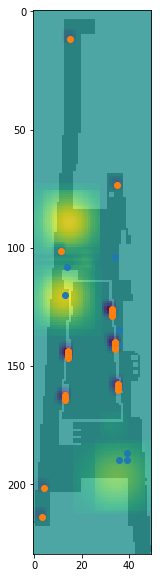

frame 31


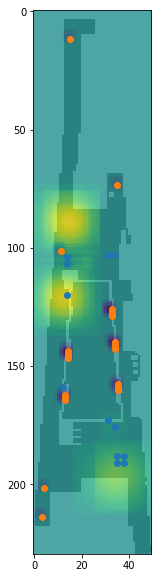

frame 32


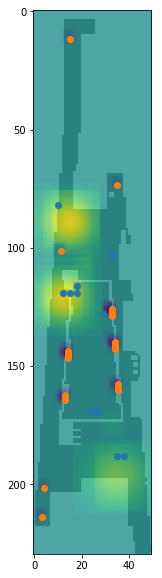

frame 33


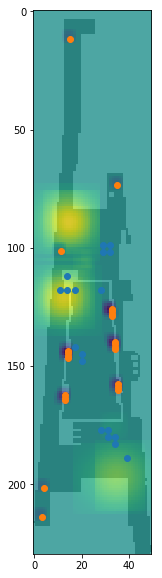

frame 34


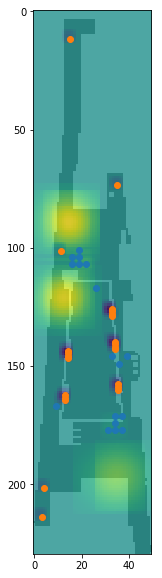

frame 35


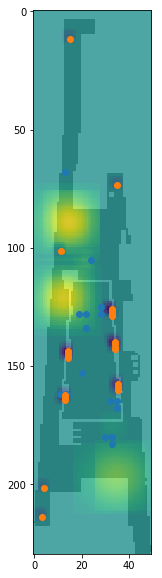

frame 36


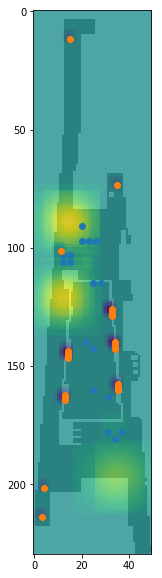

frame 37


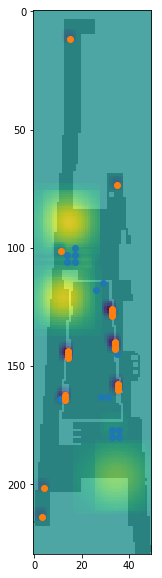

frame 38


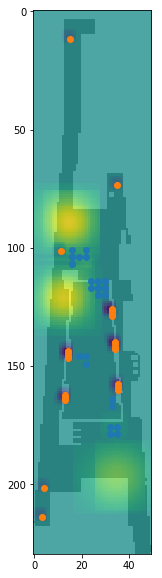

frame 39


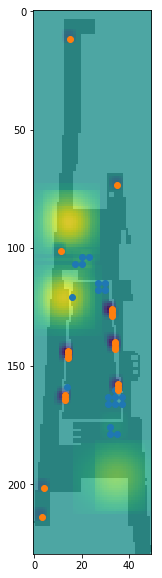

frame 40


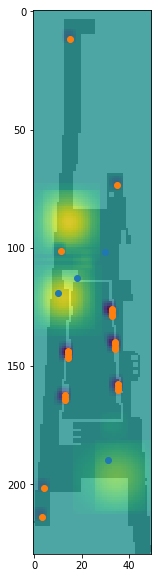

frame 41


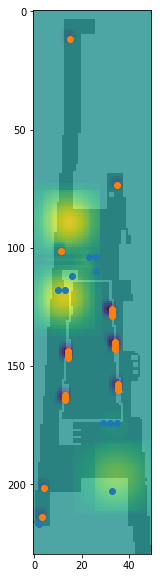

frame 42


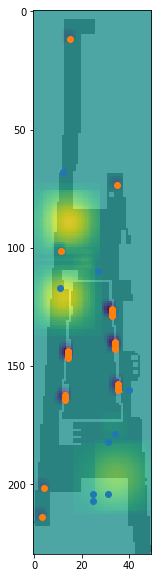

frame 43


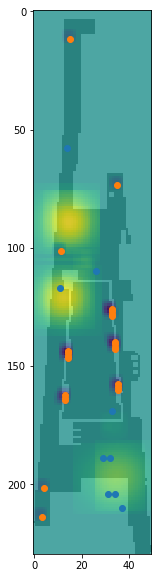

frame 44


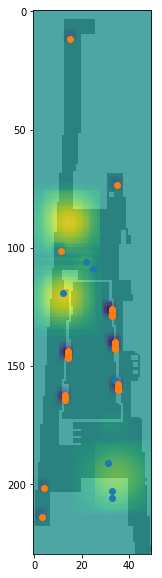

frame 45


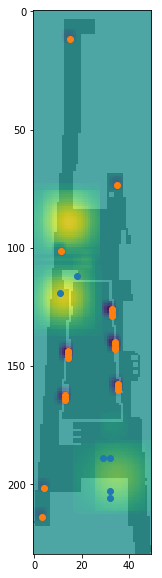

frame 46


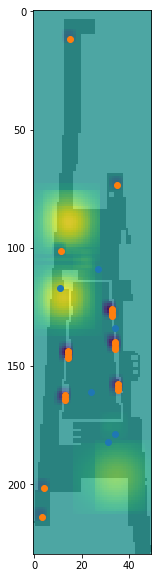

frame 47


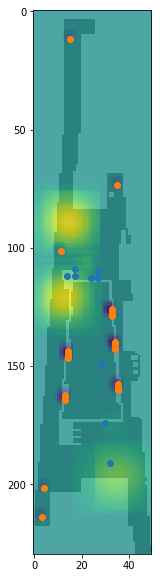

frame 48


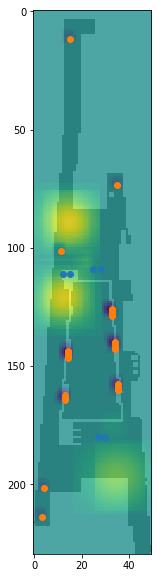

frame 49


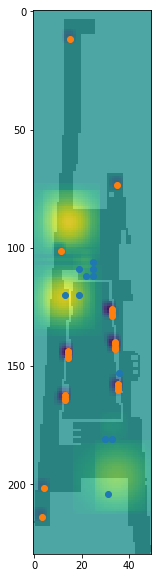

frame 50


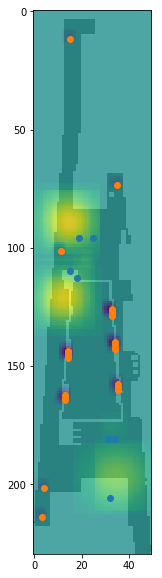

frame 51


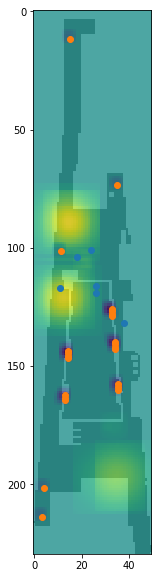

frame 52


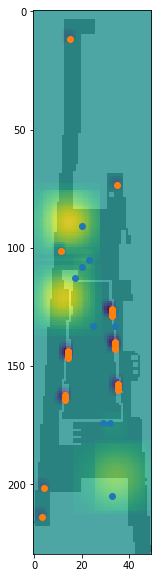

frame 53


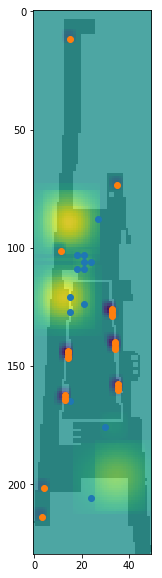

frame 54


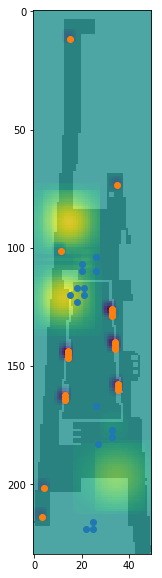

frame 55


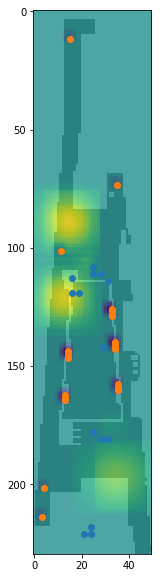

frame 56


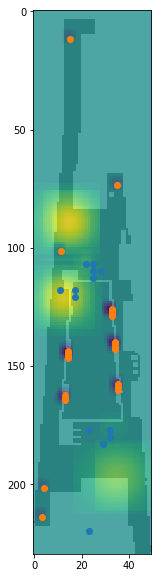

frame 57


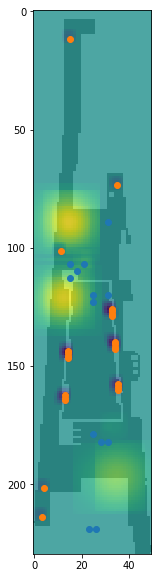

frame 58


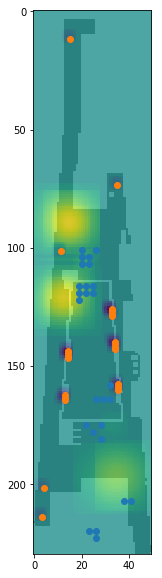

frame 59


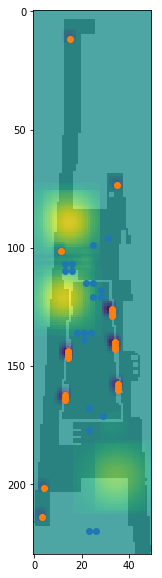

In [154]:
for i in range(60):
    print 'frame', i
    # get cluster_list
    # 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
    small_cluster = data[i]['small_clusters']

    small_cluster = pd.DataFrame(small_cluster)
    small_cluster = small_cluster[small_cluster[4] > 0]
    small_cluster.index = range(len(small_cluster))

    # 坐标-->索引
    small_cluster[0] = small_cluster[0] 
    '''看这里'''
    small_cluster[1] = 230 - small_cluster[1]

    cluster_list = np.array(small_cluster[[1,0]]).astype(int)
    cl = zip(cluster_list.tolist(), small_cluster[4]) # cl = [([197, 9], 1.0),...,([],1.0)]

    # 要删除的
    plt.rcParams['figure.figsize'] = (10,10)
    plt.imshow(M.normlize(map_data), alpha=0.7, cmap='gray')
    # plt.imshow(map_data_new, alpha=0.8, cmap='gray')
    plt.imshow(M.normlize(crowd_density-exits_density), alpha=0.8,)
    plt.scatter(small_cluster[0], small_cluster[1],)
    plt.scatter(exits_all[0], exits_all[1],)
    plt.show()